# Χρονοσειρές Lorentz

## 1. Εγκατάσταση βιβλιοθηκών
#### NumPy → ταχύς χειρισμός πινάκων.
#### SciPy → έτοιμοι ολοκληρωτές ODE (π.χ. solve_ivp).
#### Matplotlib → γραφήματα 2-D & 3-D.
#### pandas → ευέλικτο data container (DataFrame).



In [37]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp        # εναλλακτικά: from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pyrcn.echo_state_network import ESNRegressor
from numpy import array
import math
import csv


## 2. Ορισμός παραμέτρων & εξισώσεων Lorenz



In [20]:
# Παράμετροι
sigma = 10.0          # ένταση «περιστροφικού» όρου (σχετικό με Prandtl)
beta  = 8.0 / 3.0     # γεωμετρικός/αγώγιμος συντελεστής
rho   = 28.0          # «θερμική ώθηση» (Rayleigh number)

# 3.2 Συνάρτηση που δίνει τα παράγωγα
def lorenz(t, state):
    """
    t      : τρέχων χρόνος (float, αλλά δεν χρησιμοποιείται ρητά)
    state  : διάνυσμα [x, y, z] τη χρονική στιγμή t
    return : λίστα [dx/dt, dy/dt, dz/dt]
    """
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


## 3. Ρύθμιση χρονικού πλέγματος & αρχικών συνθηκών

In [14]:
t0, t_end, dt = 0.0, 50.0, 0.01       # από 0 ως 50 "δευτερόλεπτα" με βήμα 0.01
t_eval = np.arange(t0, t_end + dt, dt)  # σημείο-σημείο εξαγωγής

initial_state = [1.0, 1.0, 1.0]       # x0, y0, z0


## 4. Αριθμητική ολοκλήρωση



In [15]:
sol = solve_ivp(
    lorenz,                # η συνάρτηση με τα παράγωγα
    (t0, t_end),           # χρονικό διάστημα ολοκλήρωσης
    initial_state,         # αρχικές τιμές
    method="RK45",         # Dormand–Prince 4(5)
    t_eval=t_eval,         # πού θες αποτελέσματα
    rtol=1e-9, atol=1e-12  # έλεγχος σφάλματος
)


In [16]:
t = sol.t
x, y, z = sol.y          # "ξεδιπλώνουμε" τις τρεις χρονοσειρές


## 5. Μετατροπή σε DataFrame



In [17]:
df = (
    pd.DataFrame({"t": t, "x": x, "y": y, "z": z})
      .set_index("t")        # χρόνος ως index ⇒ έτοιμο για resample/rolling
)
df.head()                    # δείχνει τις 5 πρώτες γραμμές


,x,y,z
t,,,
0.00,1.000000,1.000000,1.000000
0.01,1.012566,1.259920,0.984891
0.02,1.048821,1.524001,0.973114
0.03,1.107206,1.798315,0.965159
0.04,1.186865,2.088546,0.961737


## 6. Οπτικοποίηση χρονοσειρών


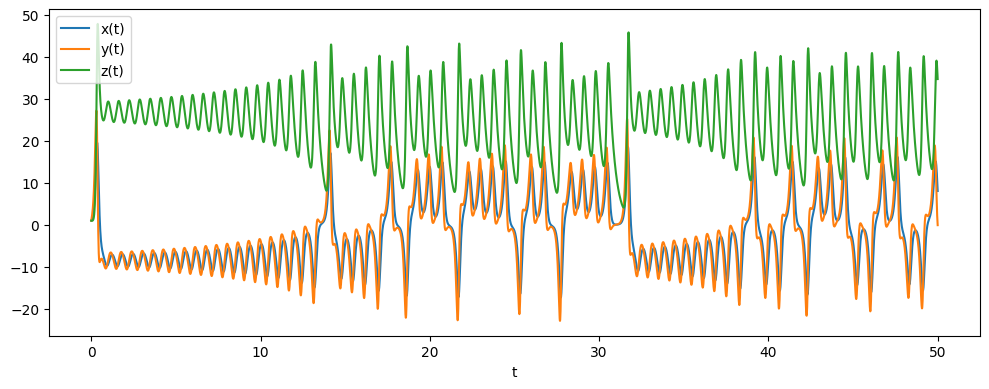

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["x"], label="x(t)")
plt.plot(df.index, df["y"], label="y(t)")
plt.plot(df.index, df["z"], label="z(t)")
plt.xlabel("t"), plt.legend(), plt.tight_layout()
plt.show()


## ελκυστής («πεταλούδα»)

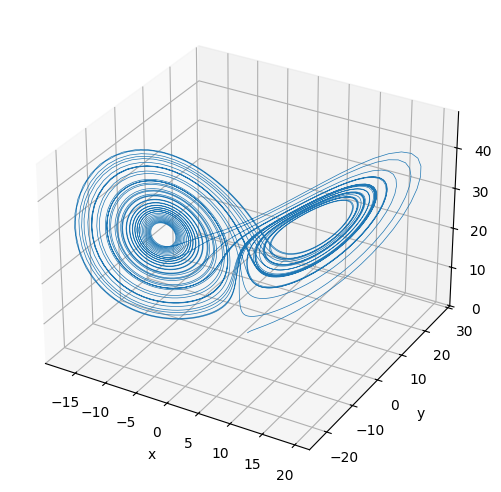

In [19]:
from mpl_toolkits.mplot3d import Axes3D  # μόνο για να ενεργοποιηθεί το 3-D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, linewidth=0.5)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")
plt.tight_layout(); plt.show()


## Κλασική “sliding-window” μετατροπή της μονοδιάστατης χρονοσειράς σε πίνακα εισόδου X διαστάσεων N×50 και αντίστοιχο διάνυσμα στόχων y
## 1. Δημιουργία παραθύρων
### Ολισθαίνουμε ένα παράθυρο μήκους 51 επάνω στη σειρά:
### Είσοδοι: οι πρώτες 50 τιμές.
### Στόχος: η 51η τιμή.
## 2. Δομές δεδομένων
### Το X_ins γίνεται λίστα από μονοδιάστατους πίνακες (arrays), καθένας σχήματος (50,)
### Το y_targets είναι λίστα με αριθμούς (scalars) — η “επόμενη” τιμή κλεισίματος που θέλουμε να προβλέψουμε
### Το prices κρατάει το τελευταίο στοιχείο κάθε παραθύρου—χρήσιμο για κανονικοποίηση ή υπολογισμό απόδοσης σε σχέση με την πιο πρόσφατη τιμή.

In [39]:
 #Διαχωρισμός δεδομένων σε είσοδοι (inputs) και στόχοι (outputs) για tuning υπερπαραμέτρων
y_targets = list()
X_ins = list()
prices = list()
# Δημιουργούμε sliding windows των 51 τιμών: 50 για είσοδο + 1 για στόχο
for i in range(len(df)):
    end = i+50+1
    if end > len(df):
        break # σταματάμε όταν δεν υπάρχουν άλλα πλήρη παράθυρα
        
# Παίρνουμε το slice των 51 τιμών από το column 'close'
    seq1 =df['x'].iloc[i:end]
    seq1 = seq1.reset_index(drop=True)
    
# Ο στόχος είναι η τελευταία τιμή του slice (51η)
    y_targets.append(seq1.iloc[-1])
# Η είσοδος είναι οι πρώτες 50 τιμές
    seq = seq1[:-1]
# Αποθηκεύουμε την τελευταία τιμή της εισόδου (συνήθως για κανονικοποίηση)
    price = seq.iloc[-1]
    prices.append(price)
    seq = np.array(seq)
    seq = np.round(seq,5)
    X_ins.append(seq)
    
# Τελικά παίρνουμε έναν πίνακα X με σχήμα (n_samples, 50)
X = np.array(X_ins)


### Αυτό σχεδιάζει το 1ό παράθυρο εισόδου (δηλαδή το 50-βηματικό ιστορικό τιμών από t=0 έως t=0.49), 
### ώστε να μπορείτε να δείτε πώς μοιάζει ένα τυπικό δείγμα εκπαίδευσης.

In [51]:
X[0]


array([ 1.     ,  1.01257,  1.04882,  1.10721,  1.18687,  1.28755,
        1.40957,  1.55369,  1.72115,  1.9136 ,  2.13311,  2.38215,
        2.66358,  2.98067,  3.33705,  3.73672,  4.18401,  4.68352,
        5.23998,  5.85815,  6.54253,  7.29705,  8.12456,  9.02623,
       10.00066, 11.04284, 12.14296, 13.28497, 14.44538, 15.59222,
       16.68481, 17.6747 , 18.50819, 19.13065, 19.49238, 19.55509,
       19.29773, 18.72015, 17.84363, 16.70801, 15.3662 , 13.87756,
       12.30145, 10.69221,  9.09584,  7.54866,  6.07717,  4.69905,
        3.42445,  2.25762])

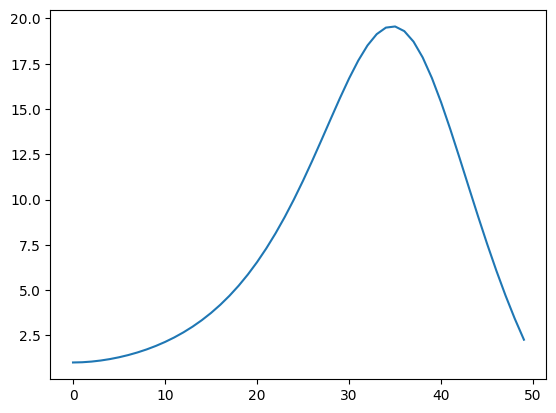

In [52]:
plt.plot(X[0])

## Διαχωρισμός σε training set & test set
### Το πρώτο 80% θα χρησιμοποιηθεί για το training set


In [56]:
#Διαχωρισμός σε training set και test set
ts = round(len(X)*0.8)
#inputs
# το πρώτο 80% train set και το υπόλοιπο test set
train_set = X[:ts]
test_set = X[ts:]
#outputs
#
y_train = y_targets[:ts]
y_test = y_targets[ts:]

# ο λόγος που χρησιμοποιούμε numpy vectors είναι γιατί πολλές βιβλιοήκες ML τα χρησιμοποιούν
y_train = np.array(y_train)
y_test = np.array(y_test)

## Εισάγουμε κάποιες βιβλιοθήκες
### 1) from sklearn.linear_model import Ridge
### Η παλινδρόμηση Ridge θα είναι το read‐out layer: ένα γραμμικό μοντέλο με L₂ κανονικοποίηση,
### που μαθαίνει να χαρτογραφεί τις καταστάσεις του reservoir στις τιμές‐στόχους.
### 2) from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
### Το GridSearchCV εκτελεί εξαντλητική αναζήτηση σε πλέγμα υπερπαραμέτρων
### (π.χ. διαφορετικά spectral_radius, leakage κ.λπ.), χρησιμοποιώντας cross‐validation
### για να επιλέξει τον καλύτερο συνδυασμό.
### Το TimeSeriesSplit είναι καταμεριστής cross‐validation που διατηρεί τη χρονολογική σειρά
### (χωρίς τυχαιοποίηση), παρέχοντας σωστά train/test folds για χρονοσειρές.
### 3) from sklearn.metrics import make_scorer, mean_squared_error
### Το mean_squared_error είναι η συνάρτηση κόστους (loss) που θα ελαχιστοποιήσετε.
### Το make_scorer(mean_squared_error, greater_is_better=False) το “τυλίγει”
### ώστε να μπορεί να περαστεί στο GridSearchCV (απαιτεί αντικείμενο scorer).
### 4) from pyrcn.model_selection import SequentialSearchCV
### Ένας PyRCN‐specific orchestrator που εκτελεί διαδοχικά βήματα tuning
### (π.χ. πρώτα input_scaling, μετά spectral_radius κ.λπ.), σταθεροποιώντας 
### κάθε φορά τις καλύτερες παραμέτρους.
### 5) from pyrcn.metrics import mean_squared_error
### Η δική του έκδοση του MSE στο PyRCN (ίδια μαθηματικά αλλά συμβατή με το API).
### 6) from pyrcn.echo_state_network import ESNRegressor
### Η κύρια κλάση που υλοποιεί το Echo State Network για regression.
### Τη δημιουργείτε με τα blocks InputToNode και NodeToNode, συν ένα read‐out (Ridge).
### 7) from pyrcn.base.blocks import InputToNode, NodeToNode
### Το InputToNode καθορίζει πώς οι είσοδοι τροφοδοτούνται (και κλιμακώνονται)
### σε κάθε νευρώνα του reservoir.
### Το NodeToNode καθορίζει τις εσωτερικές επαναληπτικές συνδέσεις
### (μέγεθος, spectral radius, leakage, sparsity κ.λπ.).
### 8) from matplotlib import pyplot as plt
### Βασική βιβλιοθήκη σχεδιασμού γραφημάτων για οπτικοποίηση:
### καμπύλες κόστους, προβλέψεις vs πραγματικά, RMSE vs υπερπαράμετροι κ.λπ.


In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from pyrcn.model_selection import SequentialSearchCV
from pyrcn.metrics import mean_squared_error
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.metrics import make_scorer,mean_squared_error

from matplotlib import pyplot as plt

## Φτιαχνουμε μία συνάρτηση που θα υπολογίζει την ελάχιστη τιμή μέσα σε μία λίστα , αυτό θα μας βοηθήσει να ΄βρίσκουμε το ελάχιστο rmse  

In [137]:
def find_min_with_index(lst):
    if not lst:
        raise ValueError("Η λίστα είναι κενή")

    minimum = lst[0]
    min_index = 0

    for i in range(1, len(lst)):  # 👈 i goes from 1 to len(lst) - 1
        if lst[i] < minimum:
            minimum = lst[i]
            min_index = i
    return minimum, min_index


# Βήμα 1: Αρχική ρύθμιση και Grid Search του ESN

In [59]:
# Απενεργοποιούμε όλες τις προειδοποιήσεις για καθαρό output
import warnings
warnings.filterwarnings('ignore')

# initially_fixed_params: λεξικό με σταθερές παραμέτρους του ESN για αυτό το βήμα.
#   hidden_layer_size=400      : αριθμός κόμβων στο reservoir
#   input_activation='identity': χωρίς μη γραμμικό μετασχηματισμό εισόδου
#   reservoir_activation='tanh': ενεργοποίηση μέσα στο reservoir
#   bidirectional=False        : καμία οπισθοδρόμηση (μόνο προς τα εμπρός)
#   alpha=1e-5                 : δύναμη κανονικοποίησης Ridge για το read-out
#   k_rec=10                   : κάθε κόμβος έχει 10 επαναληπτικές συνδέσεις
#   random_state=42            : αναπαραγωγιμότητα τυχαίων βαρών
#   requires_sequence=False    : δεν απαιτείται η ολόκληρη ακολουθία κατά το fit
initially_fixed_params = {
    'hidden_layer_size': 400,
    'input_activation': 'identity',
    'reservoir_activation': 'tanh',
    'bidirectional': False,
    'alpha': 1e-5,
    'k_rec': 10,
    'random_state': 42,
    'requires_sequence': False
}

# step1_esn_params: grid υπερπαραμέτρων για το πρώτο tuning βήμα
#   → συνολικά 2×2×2 = 8 δυνατότητες
step1_esn_params = {
    'input_scaling':  (0.1, 0.2),
    'spectral_radius': (0.1, 0.2),
    'leakage':         (0.1, 0.2)
}

# Μετατρέπουμε το MSE σε scorer για το GridSearchCV, ώστε να το ελαχιστοποιεί
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)

# Επιπλέον kwargs για το GridSearchCV:
#   verbose=5 : εμφάνιση προόδου ανά fold
#   scoring=scorer : χρήση του MSE scorer
#   n_jobs=1 : σειριακή εκτέλεση (θέσε -1 για παράλληλη)
kwargs_step1 = {
    'verbose': 5,
    'scoring': scorer,
    'n_jobs': 1
}

# Καθορίζουμε το βήμα αναζήτησης:
#   ('βημα', ΜέθοδοςCV, grid παραμέτρων, επιπλέον kwargs)
searches = [
    ('step1', GridSearchCV, step1_esn_params, kwargs_step1)
]

# Δημιουργούμε το ESNRegressor με Ridge read-out και τις σταθερές παραμέτρους
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
esn = ESNRegressor(regressor=Ridge(), **initially_fixed_params)

# Εκτελούμε SequentialSearchCV: 
#   1) παίρνει το base ESN
#   2) τρέχει το 'step1' grid search (8 συνδυασμοί) με TimeSeriesSplit
#   3) επιλέγει τις βέλτιστες input_scaling, spectral_radius, leakage
from pyrcn.model_selection import SequentialSearchCV
esn_opti = SequentialSearchCV(esn, searches=searches).fit(train_set, y_train)

# Εμφανίζουμε το βελτιστοποιημένο ESN με τις επιλεγμένες παραμέτρους
print(esn_opti)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-1.004 total time=   0.4s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.653 total time=   0.4s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.535 total time=   0.4s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-3.738 total time=   0.8s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.622 total time=   0.4s
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.840 total time=   0.4s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-1.676 total time=   0.5s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-4.243 total time=   0.4s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-1.297 total time=   0.6s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spec

## Δοκιμάζουμε διάφορες τιμές για το Input Scaling για να βρούμε την βέλτιστη

In [129]:
## Καθορίζουμε την λίστα υποψήφιων input_scaling τιμών
in_scaling = [0.1,0.2,0.3,0.4]

In [141]:
# Δημιουργούμε μια λίστα για να αποθηκεύσουμε τα RMSE για κάθε input_scaling
rmses = list()
# Βρόχος πάνω σε όλες τις τιμές του in_scaling
for i in range(len(in_scaling)):
    in_s = in_scaling[i]  # τρέχουσα τιμή input_scaling

    # Ορίζουμε το μπλοκ που τροφοδοτεί το reservoir με είσοδο

    base_input_to_nodes = InputToNode(
        hidden_layer_size=40,        # πλήθος κόμβων reservoir
        input_activation='identity',  # χωρίς μη γραμμική ενεργοποίηση στην είσοδο
        k_in=1,                       # κάθε είσοδος συνδέεται με κάθε κόμβο
        input_scaling=in_s,           # κλιμάκωση εισόδου
        bias_scaling=0.0              # χωρίς bias
    )
    
     # Ορίζουμε τις επαναληπτικές συνδέσεις του reservoir
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=40, # ίδιο πλήθος κόμβων
        spectral_radius=0.2,   # σταθερή φασματική ακτίνα
        leakage=0.2,           # σταθερός ρυθμός διαρροής
        k_rec=10               # κάθε κόμβος συνδέεται με 10 τυχαίους
    )
     
    # Δημιουργούμε το ESN με Ridge read-out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8),
        n_readout_inits=50  #n_readout_inits=50 πεταει τα πρωτα 50 βηματα για να σταθεροποιηθεί το Reservoir
    )
    
    # Εκπαιδεύουμε το ESN πάνω στο training set
    esn.fit(train_set, y_train)
    
    # Παράγουμε προβλέψεις για το ίδιο training set
    predictions = esn.predict(train_set)
    
    # Υπολογίζουμε το MSE και έπειτα το RMSE
    MSE = mean_squared_error(predictions,y_train)
    rmse = math.sqrt(MSE)
        
    # Εκτυπώνουμε και αποθηκεύουμε το RMSE
    print(rmse)
    rmses.append(rmse)

   

0.016778931905445615
0.047588303022852656
0.05729506925583015
0.057359055384956226


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [142]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Το in_scaling που αντιστοιχεί είναι:", in_scaling[index])

Η ελάχιστη τιμή είναι: 0.016778931905445615
Η θέση της είναι: 0
Το in_scaling που αντιστοιχεί είναι: 0.1


## Φτιάχνουμε ένα διάγραμμα που απεικονίζει πως συμπεριφέρεται το rmse για τις δίαφορες τιμές του input scaling

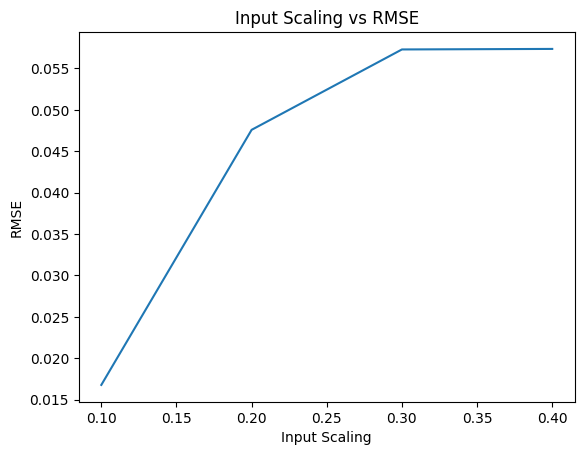

In [143]:
plt.title("Input Scaling vs RMSE")
plt.xlabel("Input Scaling")
plt.ylabel("RMSE")
plt.plot(in_scaling,rmses)

## Δοκιμάζουμε διάφορες τιμές για το Input Scaling για να βρούμε την βέλτιστη 


In [146]:
## Καθορίζουμε την λίστα υποψήφιων input_scaling τιμών
nodes = [30,40,50,60,70,80,90,100]

## Θέλουμε να δούμε πώς η απόδοση του ESN (μετρούμενη ως RMSE στο training set) αλλάζει καθώς αλλάζουμε το πλήθος των νευρώνων (nodes) στο εσωτερικό reservoir.

## Λιγότεροι κόμβοι → μικρότερη χωρητικότητα μνήμης, λιγότερο πολύπλοκο μοντέλο

## Περισσότεροι κόμβοι → περισσότερη χωρητικότητα, αλλά και κίνδυνος υπερεκπαίδευσης ή μεγαλύτερο κόστος υπολογισμού

In [148]:

# Εδώ θα αποθηκεύσουμε τα RMSE για κάθε μέγεθος
rmses = []

# Βρόχος πάνω σε κάθε αριθμό κόμβων
for i in range(len(nodes)):
    n_nodes = nodes[i]  # τρέχουσα τιμή hidden_layer_size

    # 1) Ορισμός του μπλοκ εισόδου με n_nodes νευρώνες
    base_input_to_nodes = InputToNode(
        hidden_layer_size=n_nodes,       # πλήθος νευρώνων
        input_activation='identity',     # χωρίς μη-γραμμικότητα στην είσοδο
        k_in=1,                          # πλήρης σύνδεση input → κάθε νευρώνα
        input_scaling=0.1,               # σταθερή κλιμάκωση εισόδου
        bias_scaling=0.0                 # χωρίς bias
    )

    # 2) Ορισμός του μπλοκ επαναληπτικών συνδέσεων (reservoir)
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=n_nodes,  # ίδιο πλήθος νευρώνων
        spectral_radius=0.2,        # σταθερή φασματική ακτίνα
        leakage=0.2,                # σταθερή διαρροή μνήμης
        k_rec=10,                   # 10 τυχαίες επαναληπτικές συνδέσεις ανά νευρώνα
              
    )

    # 3) Κατασκευή ESNRegressor με Ridge read‐out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8)  # πολύ ελαφριά κανονικοποίηση
    )

    # 4) Εκπαίδευση του ESN στο training set
    esn.fit(train_set, y_train)

    # 5) Πρόβλεψη πάνω στο ίδιο training set
    predictions = esn.predict(train_set)

    # 6) Υπολογισμός MSE και RMSE
    MSE = mean_squared_error(predictions, y_train)
    rmse = math.sqrt(MSE)

    # 7) Εμφάνιση και αποθήκευση του αποτελέσματος
    print(f"n_nodes={n_nodes} → RMSE={rmse:.20f}")
    rmses.append(rmse)


n_nodes=30 → RMSE=0.02370499955005272302
n_nodes=40 → RMSE=0.01402574284557523560
n_nodes=50 → RMSE=0.02979290573858441732
n_nodes=60 → RMSE=0.01119647182431988443
n_nodes=70 → RMSE=0.00898464929992475424
n_nodes=80 → RMSE=0.00858946013529339816
n_nodes=90 → RMSE=0.00757153869474747141
n_nodes=100 → RMSE=0.00490422042537100918


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [150]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Τα nodes που αντιστοιχεί είναι:", nodes[index])

Η ελάχιστη τιμή είναι: 0.004904220425371009
Η θέση της είναι: 7
Τα nodes που αντιστοιχεί είναι: 100


## Γράφημα που δείχνει ποσο μεταβάλεται το σφάλμα με βάση των αριθμών των κόμβων που επιλέχθηκε

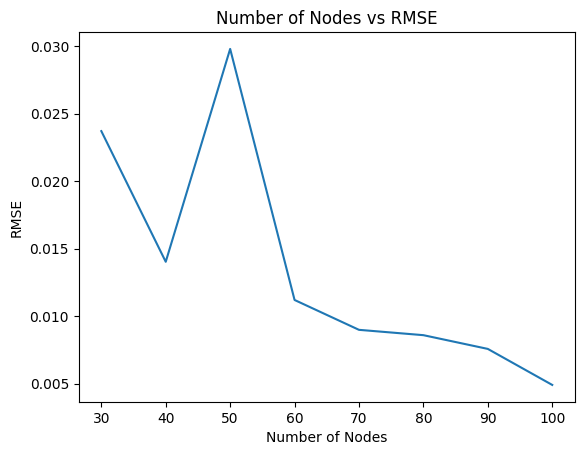

In [151]:
plt.title("Number of Nodes vs RMSE")
plt.xlabel("Number of Nodes")
plt.ylabel("RMSE")
plt.plot(nodes,rmses)

## Σε αυτό το βήμα διαμορφώνουμε την αρχιτεκτονική του Echo State Network, δημιουργώντας: 
### Το μπλοκ εισόδου (InputToNode) που χαρτογραφεί και κλιμακώνει τις εξωτερικές τιμές στο reservoir.
### Το επαναληπτικό μπλοκ (NodeToNode) που ορίζει τη δυναμική και τις εσωτερικές συνδέσεις του reservoir.
### Τον τελικό ESNRegressor, συνδυάζοντας τα δύο blocks με έναν γραμμικό Ridge read-out, έτοιμο να εκπαιδευτεί.

In [154]:
# Ορισμός του μπλοκ εισόδου (Input → Reservoir)
base_input_to_nodes = InputToNode(
    hidden_layer_size=100,   # reservoir με 1000 νευρώνες
    input_activation='identity',  # η είσοδος περνάει αυτούσια, χωρίς μη-γραμμική ενεργοποίηση
    k_in=1,                       # κάθε διάσταση εισόδου συνδέεται με κάθε νευρώνα
    input_scaling=0.1,            # κλιμακώνει την ισχύ του σήματος εισόδου στο 0.4
    bias_scaling=0.0              # δεν προστίθεται επιπλέον bias
)

# Ορισμός του επαναληπτικού μπλοκ (Reservoir → Reservoir)
base_nodes_to_nodes = NodeToNode(
    hidden_layer_size=100,  # ίδια διάσταση reservoir: 1000 νευρώνες
    spectral_radius=0.2,     # φασματική ακτίνα για σταθερότητα της δυναμικής
    leakage=0.2,             # ρυθμός "διαρροής" μνήμης των νευρώνων
    k_rec=10                 # κάθε νευρώνας έχει 10 τυχαίες επαναληπτικές συνδέσεις
)

# Συνδυασμός σε ESNRegressor με Ridge read-out
esn = ESNRegressor(
    input_to_node=base_input_to_nodes,      # το μπλοκ εισόδου που ορίσαμε
    node_to_node=base_nodes_to_nodes,       # το επαναληπτικό μπλοκ
    regressor=Ridge(alpha=1e-8)             # γραμμικός read-out με πολύ ελαφριά κανονικοποίηση
)

## Δημιουργία σετ εισόδων και στόχων για εκπαίδευση ESN βάσει sliding window.


In [187]:
# Λίστα με τα μήκη ιστορικού (μεγέθη παραθύρου) που θα αξιολογηθούν ως είσοδοι για το ESN
windows = [10,15,20,25,30,35,40,45,50,60,70,80,90,100]

In [188]:
def receive_training_sets(window):
# Ετοιμάζουμε λίστες για τους στόχους, τις εισόδους και τις τιμές «πριν»
    y_targets = list()
    X_ins     = list()
    prices    = list()
    
    # Ολισθαίνουμε ένα παράθυρο μήκους window+1 πάνω στη σειρά τιμών κλεισίματος
    for b in range(len(df)):
        end = b + window + 1
        if end > len(df):
            break  # σταματάμε όταν δεν υπάρχουν αρκετά δεδομένα για πλήρες παράθυρο

        # Παίρνουμε το slice των window+1 τιμών: οι πρώτες window για είσοδο, η τελευταία για στόχο
        seq1 = df['x'].iloc[b:end].reset_index(drop=True)

        # Ο στόχος (target) είναι η τελευταία τιμή του slice
        y_targets.append(seq1.iloc[-1])

        # Η είσοδος είναι οι πρώτες window τιμές
        seq = seq1[:-1]

        # Καταγράφουμε την τελευταία τιμή της εισόδου (για κανονικοποίηση ή έλεγχο κατεύθυνσης)
        prices.append(seq.iloc[-1])

        # Μετατρέπουμε τη σειρά εισόδου σε NumPy array και την αποθηκεύουμε
        X_ins.append(np.array(seq))

    # Στοίχιση όλων των παραθύρων εισόδου σε έναν πίνακα (n_samples, window)
    train_set = np.array(X_ins)

    # Μετατροπή λίστας στόχων και τιμών «πριν» σε πίνακες NumPy
    y_train = np.array(y_targets)
    prev    = np.array(prices)

    return train_set, y_train, prev

In [189]:
def train(train_set,y_train,previous):
    esn.fit(train_set, y_train)

    
    predictions = esn.predict (train_set)

        
    MSE = mean_squared_error(predictions,y_train)
    rmse = math.sqrt(MSE)
    
    return rmse
    

In [190]:
rmses = []

## Αυτός ο βρόχος δοκιμάζει διαφορετικά μεγέθη «παραθύρου» (window sizes) και καταγράφει πόσο καλά εκπαιδεύεται το ESN σε κάθε περίπτωση:

In [191]:
# Βρόχος σε όλους τους μεγέθους παραθύρου της λίστας 'windows'
for n in range(len(windows)):
    window = windows[n]  # τρέχον μέγεθος παραθύρου

    # Δημιουργούμε τα training δεδομένα (παράθυρα εισόδου, στόχοι, προηγούμενες τιμές)
    train_set, y_train, prev = receive_training_sets(window)

    # Εκπαιδεύουμε το ESN με αυτά τα δεδομένα και υπολογίζουμε το RMSE
    rmse = train(train_set, y_train, prev)

    # Εκτυπώνουμε το RMSE για το τρέχον μέγεθος παραθύρου
    print(f"window={window} -> RMSE={rmse:.15f}")

    # Αποθηκεύουμε το RMSE στη λίστα για μελλοντική ανάλυση ή οπτικοποίηση
    rmses.append(rmse)

    

window=10 -> RMSE=0.008388018663296
window=15 -> RMSE=0.013182600710260
window=20 -> RMSE=0.025186005995075
window=25 -> RMSE=0.037185233898438
window=30 -> RMSE=0.046025915642951
window=35 -> RMSE=0.047795643621060
window=40 -> RMSE=0.043776124715232
window=45 -> RMSE=0.022608166074121
window=50 -> RMSE=0.006041078177305
window=60 -> RMSE=0.015559551800033
window=70 -> RMSE=0.024324979114921
window=80 -> RMSE=0.029225644607690
window=90 -> RMSE=0.035750940446268
window=100 -> RMSE=0.039460067246876


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [193]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Το window που αντιστοιχεί είναι:", windows[index])


Η ελάχιστη τιμή είναι: 0.006041078177305023
Η θέση της είναι: 8
Το window που αντιστοιχεί είναι: 50


## Γράφημα μεταβολής του σφάλματος με βάση το windows size

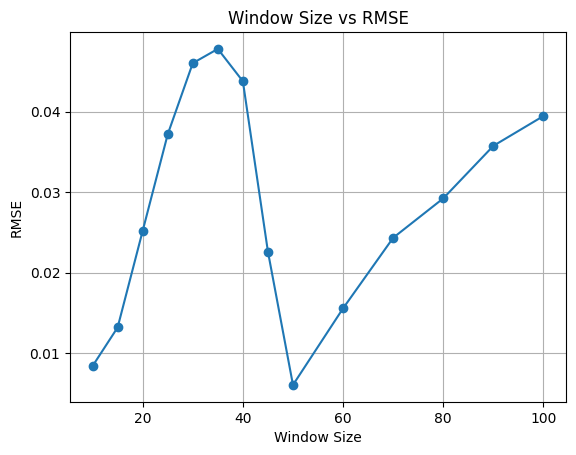

In [194]:
plt.title("Window Size vs RMSE")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.plot(windows, rmses, marker='o')  # note: use rmses, not rmse
plt.grid(True)
plt.show()


## Κλασική “sliding-window” μετατροπή της μονοδιάστατης χρονοσειράς σε πίνακα εισόδου X διαστάσεων N×50 και αντίστοιχο διάνυσμα στόχων y
## 1. Δημιουργία παραθύρων
### Ολισθαίνουμε ένα παράθυρο μήκους 51 επάνω στη σειρά:
### Είσοδοι: οι πρώτες 50 τιμές.
### Στόχος: η 51η τιμή.
## 2. Δομές δεδομένων
### Το X_ins γίνεται λίστα από μονοδιάστατους πίνακες (arrays), καθένας σχήματος (50,)
### Το y_targets είναι λίστα με αριθμούς (scalars) — η “επόμενη” τιμή κλεισίματος που θέλουμε να προβλέψουμε
### Το prices κρατάει το τελευταίο στοιχείο κάθε παραθύρου—χρήσιμο για κανονικοποίηση ή υπολογισμό απόδοσης σε σχέση με την πιο πρόσφατη τιμή.

In [196]:
y_targets = list()
X_ins = list()
prices = list()
for i in range(len(df)):
    end = i+50+1
    if end > len(df):
        break
    seq1 = df['x'].iloc[i:end]
    seq1 = seq1.reset_index(drop=True)

    y_targets.append(seq1.iloc[-1])
    
    seq = seq1[:-1]
    
    price = seq.iloc[-1]
    prices.append(price)
    seq = np.array(seq)
    seq = np.round(seq,5)
    X_ins.append(seq)
    

X = np.array(X_ins)

## Διαχωρισμός σε training set & test set
### Το πρώτο 80% θα χρησιμοποιηθεί για το training set

In [197]:
ts = round(len(X)*0.8)
#inputs
train_set = X[:ts]
test_set = X[ts:]
#outputs
y_train = y_targets[:ts]
y_test = y_targets[ts:]

y_train = np.array(y_train)
y_test = np.array(y_test)

In [201]:
# Εκπαίδευση (fit) του ESN στο training set
#   - Το ESN «μαθαίνει» τον γραμμικό read-out (Ridge) βασιζόμενο στις καταστάσεις του reservoir
#   - Χρησιμοποιεί train_set (X) και y_train (στόχους) για να υπολογίσει τα κατάλληλα βάρη
esn.fit(train_set, y_train)

# Πρόβλεψη (predict) του ίδιου training set
#   - Μετά την εκπαίδευση, παράγει τις τιμές που «πιστεύει» ότι αντιστοιχούν στα train_set
#   - Αποθηκεύουμε το αποτέλεσμα σε predictions_train
predictions_train = esn.predict(train_set)


## Σχεδιασμός των πρώτων 30 προβλέψεων του μοντέλου συγκριτικά με τις πραγματικές τιμές, ώστε να δεις σε ένα μικρό «παράθυρο» πώς τα πάει:


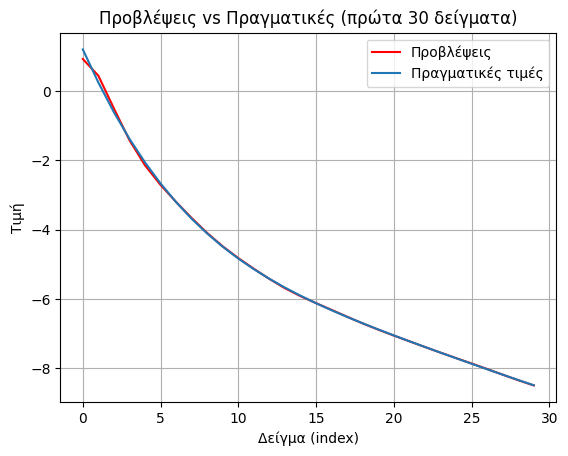

In [203]:
# Σχεδιάζουμε τις πρώτες 30 προβλέψεις (κόκκινη γραμμή)
plt.plot(predictions_train[:30], color='red', label='Προβλέψεις')

# Σχεδιάζουμε τις πρώτες 30 πραγματικές τιμές (μπλε γραμμή από προεπιλογή)
plt.plot(y_train[:30],       label='Πραγματικές τιμές')

# Προσθέτουμε υπόμνημα και άξονες
plt.legend()
plt.xlabel('Δείγμα (index)')
plt.ylabel('Τιμή')
plt.title('Προβλέψεις vs Πραγματικές (πρώτα 30 δείγματα)')
plt.grid(True)
plt.show()

## Αυτή η διαδικασία υπολογίζει πόσες φορές το ESN “έπιασε” σωστά την τάση (πάνω ή κάτω) της τιμής σε σχέση με την προηγούμενη τιμή του παραθύρου στο Training set :

In [205]:
# Ορισμός των πινάκων για έλεγχο κατεύθυνσης πρόβλεψης
real        = y_train                # οι πραγματικές επόμενες τιμές
predictions = predictions_train      # οι προβλέψεις του ESN για το training set

# Το prev παίρνει τις «τελευταίες» τιμές κάθε παραθύρου εισόδου
prev = np.array(prices[:ts])


# Μετρητής σωστών προβλέψεων κατεύθυνσης
number = 0

# Βρόχος σε κάθε δείγμα για να ελέγξουμε αν το μοντέλο έπιασε
# σωστά αν η τιμή ανέβηκε ή έπεσε σε σχέση με την προηγούμενη τιμή
for i in range(len(real)):
    # Αν και η πραγματική και η προβλεπόμενη τιμή είναι πάνω
    # από το prev[i], μετράμε σωστή ανοδική πρόβλεψη
    if real[i] > prev[i] and predictions[i] > prev[i]:
        number += 1
    # Αν και οι δύο είναι κάτω από το prev[i], μετράμε σωστή καθοδική πρόβλεψη
    elif real[i] < prev[i] and predictions[i] < prev[i]:
        number += 1
    # Διαφορετικά δεν αυξάνουμε τον μετρητή

# Υπολογισμός ποσοστού επιτυχίας ως προς την κατεύθυνση (directional accuracy)
trues = number / len(real)
print(trues)  # π.χ. 0.513 σημαίνει 51.3% σωστές προβλέψεις κατεύθυνσης


0.9987376925018935


## esn.predict(test_set): χρησιμοποιεί το ήδη “εκπαιδευμένο” μοντέλο (esn.fit έχει ήδη τρέξει) ώστε να εκτιμήσει τις επόμενες τιμές για κάθε παράθυρο στο test_set.

### Το αποτέλεσμα predictions_test είναι ένας πίνακας με μήκος όμοιο με το test_set, που περιέχει τις προβλεπόμενες τιμές για κάθε δείγμα του test set.

In [207]:
# Παράγουμε τις προβλέψεις του ESN για τα νέα, αθέατα δεδομένα του test set
predictions_test = esn.predict(test_set)

In [208]:
len(predictions_test)

990

In [209]:
len(y_test)

990

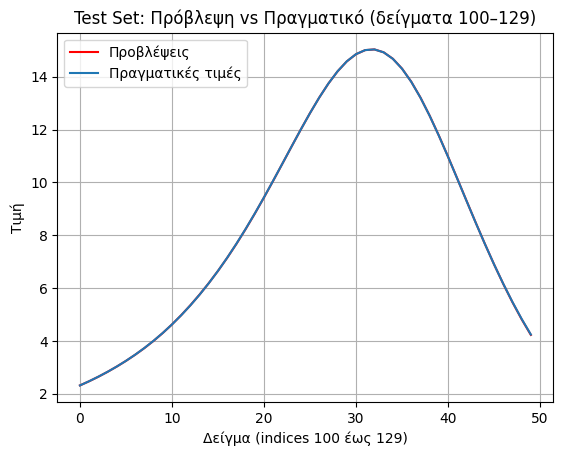

In [218]:
# Σχεδίασε τις προβλέψεις 100–129 (κόκκινη γραμμή)
plt.plot(predictions_test[100:150], color='red', label='Προβλέψεις')

# Σχεδίασε τις πραγματικές τιμές 100–129 (μπλε γραμμή)
plt.plot(y_test[100:150], label='Πραγματικές τιμές')

# Προσθήκη υπόμνηματος και τίτλων αξόνων
plt.legend()
plt.xlabel('Δείγμα (indices 100 έως 129)')
plt.ylabel('Τιμή')
plt.title('Test Set: Πρόβλεψη vs Πραγματικό (δείγματα 100–129)')
plt.grid(True)
plt.show()

## Αυτό το κομμάτι κώδικα υπολογίζει την «κατευθυντική ακρίβεια» (directional accuracy) του μοντέλου στο test set, δηλαδή το ποσοστό των φορών που μάντεψε σωστά αν η τιμή θα κινηθεί πάνω ή κάτω σε σχέση με την προηγούμενη τιμή.

In [212]:
# Ορισμός των πινάκων για έλεγχο κατεύθυνσης
real        = y_test                # πραγματικές τιμές-στόχοι
predictions = predictions_test      # προβλεπόμενες τιμές ESN
prev        = np.array(prices[ts:]) # τελευταία τιμή κάθε window για το test set

# Αρχικοποίηση μετρητή σωστών προβλέψεων κατεύθυνσης
number = 0

# Για κάθε δείγμα i, ελέγχουμε αν το μοντέλο μάντεψε σωστά την ανοδική/καθοδική κίνηση
for i in range(len(real)):
    # Σωστή ανοδική πρόβλεψη αν και η πραγματική και η προβλεπόμενη > prev[i]
    if real[i] > prev[i] and predictions[i] > prev[i]:
        number += 1
    # Σωστή καθοδική πρόβλεψη αν και οι δύο < prev[i]
    elif real[i] < prev[i] and predictions[i] < prev[i]:
        number += 1
    # Στις άλλες περιπτώσεις δεν μετράμε τίποτα

# Υπολογισμός ποσοστού επιτυχίας (directional accuracy)
trues = number / len(real)
print(trues)  # π.χ. 0.504 → 50.4% σωστές προβλέψεις κατεύθυνσης

0.9848484848484849
